## Import packages

In [ ]:
import sys
print(sys.version)  # Print Python version in use

import numpy as np                                      # Array operations
import matplotlib.pyplot as plt                         # Plotting library
import torch                                            # Main PyTorch library
import torch.optim as optim                             # Optimization algorithms
from torch import nn                                    # Neural network modules
from torch.utils.data import Dataset, DataLoader        # Dataset and batch data loading
from datetime import datetime                           # Date/time utilities
import os                                               # Operating system utilities
import pandas as pd                                     # Data manipulation
import rasterio                                         # Geospatial raster data

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# Set random seed for reproducibility
seed = 42

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


### If using Google Colab, uncomment the following lines

The file directories will also need to be changed to match the location of the files in your Google Drive.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import data

## Set paths to data

In [ ]:
buffalo_id = 2005
n_samples = 10297

# Specify the path to CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Path to your TIF file (slope)
slope_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_slope_cent101x101_lag_1hr_n{n_samples}.tif'

# Paths to the Sentinel-2 bands
b1_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b1_cent101x101_lag_1hr_n{n_samples}.tif'
b2_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b2_cent101x101_lag_1hr_n{n_samples}.tif'
b3_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b3_cent101x101_lag_1hr_n{n_samples}.tif'
b4_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b4_cent101x101_lag_1hr_n{n_samples}.tif'
b5_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b5_cent101x101_lag_1hr_n{n_samples}.tif'
b6_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b6_cent101x101_lag_1hr_n{n_samples}.tif'
b7_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b7_cent101x101_lag_1hr_n{n_samples}.tif'
b8_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b8_cent101x101_lag_1hr_n{n_samples}.tif'
b8a_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b8a_cent101x101_lag_1hr_n{n_samples}.tif'
b9_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b9_cent101x101_lag_1hr_n{n_samples}.tif'
b11_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b11_cent101x101_lag_1hr_n{n_samples}.tif'
b12_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_s2_b12_cent101x101_lag_1hr_n{n_samples}.tif'

# Path to your TIF file (target variable)
pres_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_pres_cent101x101_lag_1hr_n{n_samples}.tif'


## Read buffalo data

In [3]:
# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)
print(buffalo_df.shape)

# Lag the values in column 'A' by one index to get the bearing of the previous step
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

(10103, 35)
             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

     cos_ta         x_min         x_max         y_min         y_max  s2_index  \
0  0.

## Importing spatial data

## Slope

In [5]:
# Using rasterio
with rasterio.open(slope_path) as slope:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    slope_stack = slope.read([i for i in range(1, slope.count + 1)])

print(slope_stack.shape)

(10103, 101, 101)


In [6]:
# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
slope_tens = torch.from_numpy(slope_stack)
print(slope_tens.shape)

# Print the mean, max, and min values of the slope tensor
print("Mean = ", torch.mean(slope_tens))
slope_max = torch.max(slope_tens)
slope_min = torch.min(slope_tens)
print("Max = ", slope_max)
print("Min = ", slope_min)

# Normalizing the data
slope_tens_norm = (slope_tens - slope_min) / (slope_max - slope_min)
print("Mean = ", torch.mean(slope_tens_norm))
print("Max = ", torch.max(slope_tens_norm))
print("Min = ", torch.min(slope_tens_norm))

torch.Size([10103, 101, 101])
Mean =  tensor(0.7779)
Max =  tensor(12.2981)
Min =  tensor(0.0006)
Mean =  tensor(0.0632)
Max =  tensor(1.)
Min =  tensor(0.)


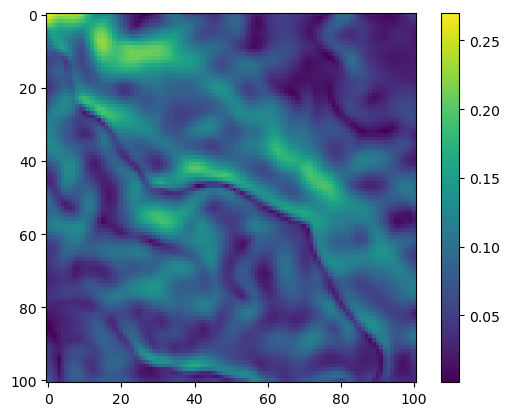

In [7]:
for i in range(0, 1):
    plt.imshow(slope_tens_norm[i])
    plt.colorbar()
    plt.show()

## Sentinel-2 bands

### Band 1

In [9]:
# Using rasterio
with rasterio.open(b1_path) as b1:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b1_stack = b1.read([i for i in range(1, b1.count + 1)])

In [ ]:
# Print the shape of the original b1_stack array
print(b1_stack.shape)

# Replace NaNs with -1
b1_stack = np.nan_to_num(b1_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor
b1_tens = torch.from_numpy(b1_stack)
print(b1_tens.shape)

# Display the mean, max, and min values of the b1 tensor
print("Mean =", torch.mean(b1_tens))
b1_max = torch.max(b1_tens)
b1_min = torch.min(b1_tens)
print("Max =", b1_max)
print("Min =", b1_min)

# Data normalization
# Note: The data is already normalized by 10000 during preprocessing,
# so we simply assign the original tensor.
b1_tens_norm = b1_tens
print("Mean =", torch.mean(b1_tens_norm))
print("Max =", torch.max(b1_tens_norm))
print("Min =", torch.min(b1_tens_norm))

(10103, 101, 101)
torch.Size([10103, 101, 101])
Mean = tensor(0.0444)
Max = tensor(0.1517)
Min = tensor(1.0000e-04)
Mean = tensor(0.0444)
Max = tensor(0.1517)
Min = tensor(1.0000e-04)


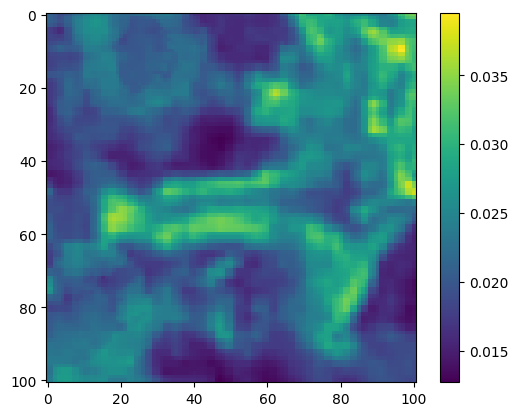

In [ ]:
for i in range(0, 1):
    plt.imshow(b1_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 2

In [ ]:
# Using rasterio
with rasterio.open(b2_path) as b2:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b2_stack = b2.read([i for i in range(1, b2.count + 1)])


In [ ]:
print(b2_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b2_stack = np.nan_to_num(b2_stack, nan=-1.0)

b2_tens = torch.from_numpy(b2_stack)

print(b2_tens.shape)
print("Mean = ", torch.mean(b2_tens))

b2_max = torch.max(b2_tens)
b2_min = torch.min(b2_tens)

print("Max = ", b2_max)
print("Min = ", b2_min)

# Normalizing the data
b2_tens_norm = (b2_tens - b2_min) / (b2_max - b2_min)
print("Mean = ", torch.mean(b2_tens_norm))
print("Max = ", torch.max(b2_tens_norm))
print("Min = ", torch.min(b2_tens_norm))

# print(b2_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.0548)
Max =  tensor(0.1808)
Min =  tensor(0.0061)
Mean =  tensor(0.2787)
Max =  tensor(1.)
Min =  tensor(0.)


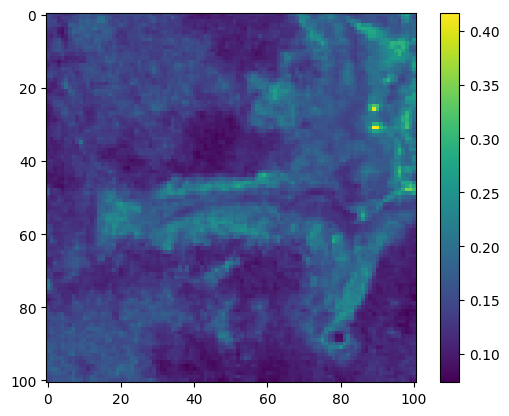

In [ ]:
for i in range(0, 1):
    plt.imshow(b2_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 3

In [ ]:
# Using rasterio
with rasterio.open(b3_path) as b3:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b3_stack = b3.read([i for i in range(1, b3.count + 1)])


In [ ]:
print(b3_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b3_stack = np.nan_to_num(b3_stack, nan=-1.0)

b3_tens = torch.from_numpy(b3_stack)

print(b3_tens.shape)
print("Mean = ", torch.mean(b3_tens))

b3_max = torch.max(b3_tens)
b3_min = torch.min(b3_tens)

print("Max = ", b3_max)
print("Min = ", b3_min)

# Normalizing the data
b3_tens_norm = (b3_tens - b3_min) / (b3_max - b3_min)
print("Mean = ", torch.mean(b3_tens_norm))
print("Max = ", torch.max(b3_tens_norm))
print("Min = ", torch.min(b3_tens_norm))

# print(b3_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.0749)
Max =  tensor(0.2210)
Min =  tensor(0.0155)
Mean =  tensor(0.2892)
Max =  tensor(1.)
Min =  tensor(0.)


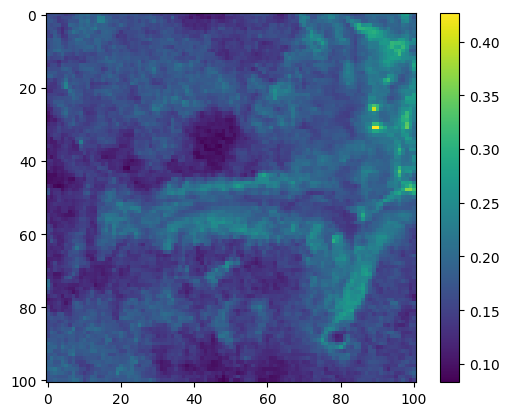

In [ ]:
for i in range(0, 1):
    plt.imshow(b3_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 4

In [ ]:
# Using rasterio
with rasterio.open(b4_path) as b4:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b4_stack = b4.read([i for i in range(1, b4.count + 1)])


In [ ]:
print(b4_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b4_stack = np.nan_to_num(b4_stack, nan=-1.0)

b4_tens = torch.from_numpy(b4_stack)

print(b4_tens.shape)
print("Mean = ", torch.mean(b4_tens))

b4_max = torch.max(b4_tens)
b4_min = torch.min(b4_tens)

print("Max = ", b4_max)
print("Min = ", b4_min)

# Normalizing the data
b4_tens_norm = (b4_tens - b4_min) / (b4_max - b4_min)
print("Mean = ", torch.mean(b4_tens_norm))
print("Max = ", torch.max(b4_tens_norm))
print("Min = ", torch.min(b4_tens_norm))

# print(b4_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.0876)
Max =  tensor(0.2712)
Min =  tensor(0.0111)
Mean =  tensor(0.2941)
Max =  tensor(1.)
Min =  tensor(0.)


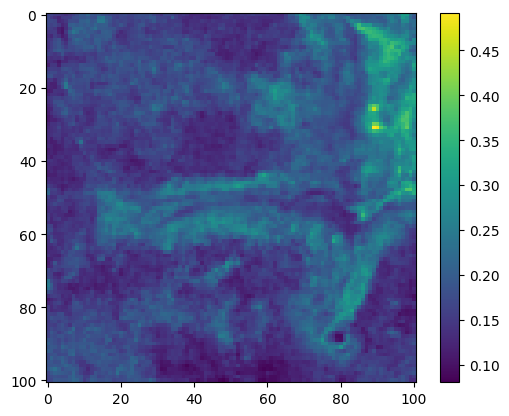

In [ ]:
for i in range(0, 1):
    plt.imshow(b4_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 5

In [ ]:
# Using rasterio
with rasterio.open(b5_path) as b5:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b5_stack = b5.read([i for i in range(1, b5.count + 1)])


In [ ]:
print(b5_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b5_stack = np.nan_to_num(b5_stack, nan=-1.0)

b5_tens = torch.from_numpy(b5_stack)

print(b5_tens.shape)
print("Mean = ", torch.mean(b5_tens))

b5_max = torch.max(b5_tens)
b5_min = torch.min(b5_tens)

print("Max = ", b5_max)
print("Min = ", b5_min)

# Normalizing the data
b5_tens_norm = (b5_tens - b5_min) / (b5_max - b5_min)
print("Mean = ", torch.mean(b5_tens_norm))
print("Max = ", torch.max(b5_tens_norm))
print("Min = ", torch.min(b5_tens_norm))

# print(b5_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.1194)
Max =  tensor(0.2995)
Min =  tensor(0.0294)
Mean =  tensor(0.3331)
Max =  tensor(1.)
Min =  tensor(0.)


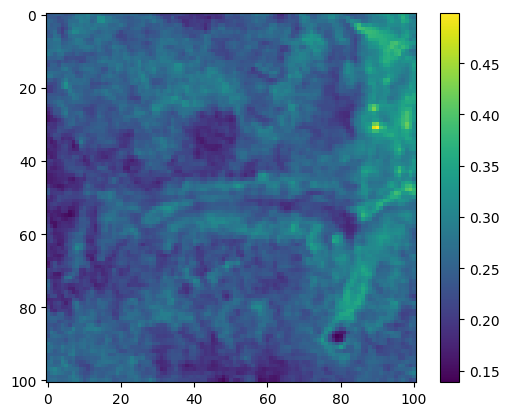

In [ ]:
for i in range(0, 1):
    plt.imshow(b5_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 6

In [ ]:
# Using rasterio
with rasterio.open(b6_path) as b6:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b6_stack = b6.read([i for i in range(1, b6.count + 1)])


In [ ]:
print(b6_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b6_stack = np.nan_to_num(b6_stack, nan=-1.0)

b6_tens = torch.from_numpy(b6_stack)

print(b6_tens.shape)
print("Mean = ", torch.mean(b6_tens))

b6_max = torch.max(b6_tens)
b6_min = torch.min(b6_tens)

print("Max = ", b6_max)
print("Min = ", b6_min)

# Normalizing the data
b6_tens_norm = (b6_tens - b6_min) / (b6_max - b6_min)
print("Mean = ", torch.mean(b6_tens_norm))
print("Max = ", torch.max(b6_tens_norm))
print("Min = ", torch.min(b6_tens_norm))

# print(b6_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.1585)
Max =  tensor(0.3931)
Min =  tensor(0.0316)
Mean =  tensor(0.3509)
Max =  tensor(1.)
Min =  tensor(0.)


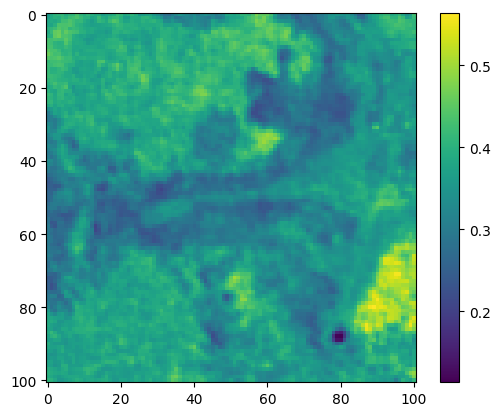

In [ ]:
for i in range(0, 1):
    plt.imshow(b6_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 7

In [ ]:
# Using rasterio
with rasterio.open(b7_path) as b7:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b7_stack = b7.read([i for i in range(1, b7.count + 1)])


In [ ]:
print(b7_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b7_stack = np.nan_to_num(b7_stack, nan=-1.0)

b7_tens = torch.from_numpy(b7_stack)

print(b7_tens.shape)
print("Mean = ", torch.mean(b7_tens))

b7_max = torch.max(b7_tens)
b7_min = torch.min(b7_tens)

print("Max = ", b7_max)
print("Min = ", b7_min)

# Normalizing the data
b7_tens_norm = (b7_tens - b7_min) / (b7_max - b7_min)
print("Mean = ", torch.mean(b7_tens_norm))
print("Max = ", torch.max(b7_tens_norm))
print("Min = ", torch.min(b7_tens_norm))

# print(b7_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.1803)
Max =  tensor(0.4810)
Min =  tensor(0.0356)
Mean =  tensor(0.3249)
Max =  tensor(1.)
Min =  tensor(0.)


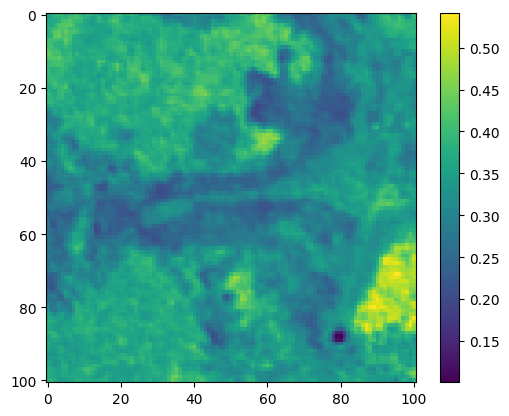

In [ ]:
for i in range(0, 1):
    plt.imshow(b7_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 8

In [ ]:
# Using rasterio
with rasterio.open(b8_path) as b8:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b8_stack = b8.read([i for i in range(1, b8.count + 1)])


In [ ]:
print(b8_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b8_stack = np.nan_to_num(b8_stack, nan=-1.0)

b8_tens = torch.from_numpy(b8_stack)

print(b8_tens.shape)
print("Mean = ", torch.mean(b8_tens))

b8_max = torch.max(b8_tens)
b8_min = torch.min(b8_tens)

print("Max = ", b8_max)
print("Min = ", b8_min)

# Normalizing the data
b8_tens_norm = (b8_tens - b8_min) / (b8_max - b8_min)
print("Mean = ", torch.mean(b8_tens_norm))
print("Max = ", torch.max(b8_tens_norm))
print("Min = ", torch.min(b8_tens_norm))

# print(b8_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.1874)
Max =  tensor(0.4787)
Min =  tensor(0.0307)
Mean =  tensor(0.3497)
Max =  tensor(1.)
Min =  tensor(0.)


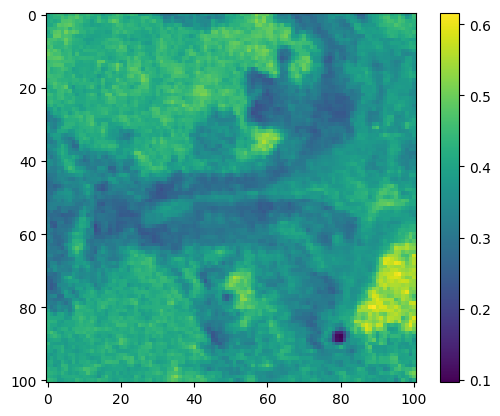

In [ ]:
for i in range(0, 1):
    plt.imshow(b8_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 8a

In [ ]:
# Using rasterio
with rasterio.open(b8a_path) as b8a:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b8a_stack = b8a.read([i for i in range(1, b8a.count + 1)])


In [ ]:
print(b8a_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b8a_stack = np.nan_to_num(b8a_stack, nan=-1.0)

b8a_tens = torch.from_numpy(b8a_stack)

print(b8a_tens.shape)
print("Mean = ", torch.mean(b8a_tens))

b8a_max = torch.max(b8a_tens)
b8a_min = torch.min(b8a_tens)

print("Max = ", b8a_max)
print("Min = ", b8a_min)

# Normalizing the data
b8a_tens_norm = (b8a_tens - b8a_min) / (b8a_max - b8a_min)
print("Mean = ", torch.mean(b8a_tens_norm))
print("Max = ", torch.max(b8a_tens_norm))
print("Min = ", torch.min(b8a_tens_norm))

# print(b8a_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.2070)
Max =  tensor(0.5103)
Min =  tensor(0.0301)
Mean =  tensor(0.3683)
Max =  tensor(1.)
Min =  tensor(0.)


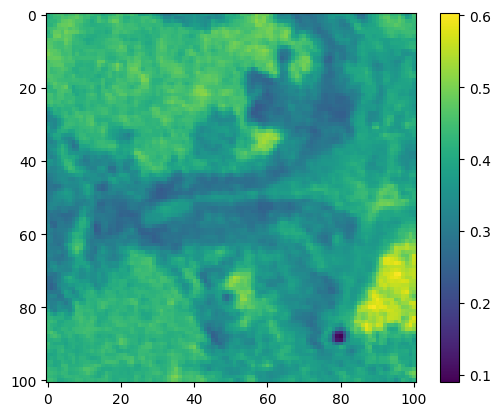

In [ ]:
for i in range(0, 1):
    plt.imshow(b8a_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 9

In [ ]:
# Using rasterio
with rasterio.open(b9_path) as b9:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b9_stack = b9.read([i for i in range(1, b9.count + 1)])


In [ ]:
print(b9_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b9_stack = np.nan_to_num(b9_stack, nan=-1.0)

b9_tens = torch.from_numpy(b9_stack)

print(b9_tens.shape)
print("Mean = ", torch.mean(b9_tens))

b9_max = torch.max(b9_tens)
b9_min = torch.min(b9_tens)

print("Max = ", b9_max)
print("Min = ", b9_min)

# Normalizing the data
b9_tens_norm = (b9_tens - b9_min) / (b9_max - b9_min)
print("Mean = ", torch.mean(b9_tens_norm))
print("Max = ", torch.max(b9_tens_norm))
print("Min = ", torch.min(b9_tens_norm))

# print(b9_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.2067)
Max =  tensor(0.4713)
Min =  tensor(0.0358)
Mean =  tensor(0.3923)
Max =  tensor(1.)
Min =  tensor(0.)


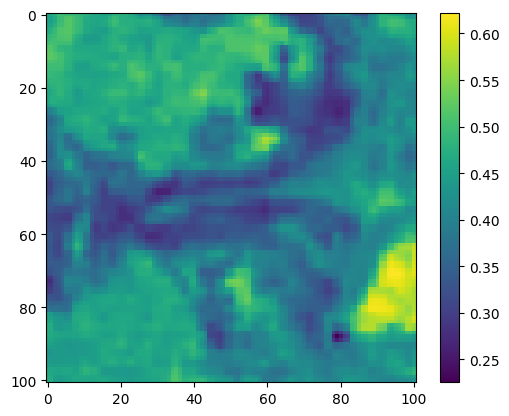

In [ ]:
for i in range(0, 1):
    plt.imshow(b9_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 11

In [ ]:
# Using rasterio
with rasterio.open(b11_path) as b11:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b11_stack = b11.read([i for i in range(1, b11.count + 1)])


In [ ]:
print(b11_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b11_stack = np.nan_to_num(b11_stack, nan=-1.0)

b11_tens = torch.from_numpy(b11_stack)

print(b11_tens.shape)
print("Mean = ", torch.mean(b11_tens))

b11_max = torch.max(b11_tens)
b11_min = torch.min(b11_tens)

print("Max = ", b11_max)
print("Min = ", b11_min)

# Normalizing the data
b11_tens_norm = (b11_tens - b11_min) / (b11_max - b11_min)
print("Mean = ", torch.mean(b11_tens_norm))
print("Max = ", torch.max(b11_tens_norm))
print("Min = ", torch.min(b11_tens_norm))

# print(b11_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.2691)
Max =  tensor(0.7314)
Min =  tensor(0.0248)
Mean =  tensor(0.3458)
Max =  tensor(1.)
Min =  tensor(0.)


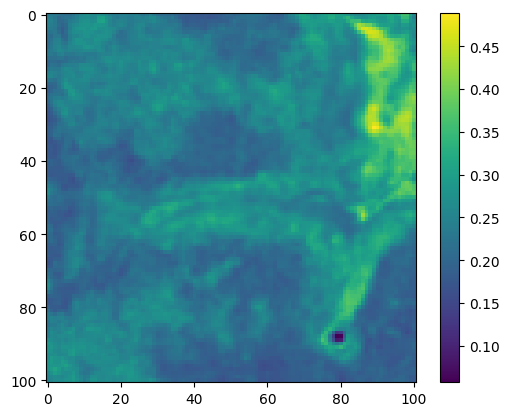

In [ ]:
for i in range(0, 1):
    plt.imshow(b11_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Band 12

In [ ]:
# Using rasterio
with rasterio.open(b12_path) as b12:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    b12_stack = b12.read([i for i in range(1, b1.count + 1)])


In [ ]:
print(b12_stack.shape)
# print(ndvi_stack.size)

# Replace NaNs in the original array with -1, which represents water
b12_stack = np.nan_to_num(b12_stack, nan=-1.0)

b12_tens = torch.from_numpy(b12_stack)

print(b12_tens.shape)
print("Mean = ", torch.mean(b12_tens))

b12_max = torch.max(b12_tens)
b12_min = torch.min(b12_tens)

print("Max = ", b12_max)
print("Min = ", b12_min)

# Normalizing the data
b12_tens_norm = (b12_tens - b12_min) / (b12_max - b12_min)
print("Mean = ", torch.mean(b12_tens_norm))
print("Max = ", torch.max(b12_tens_norm))
print("Min = ", torch.min(b12_tens_norm))

# print(b12_tens_norm.dtype)


(5145, 101, 101)
torch.Size([5145, 101, 101])
Mean =  tensor(0.1953)
Max =  tensor(0.5885)
Min =  tensor(0.0174)
Mean =  tensor(0.3116)
Max =  tensor(1.)
Min =  tensor(0.)


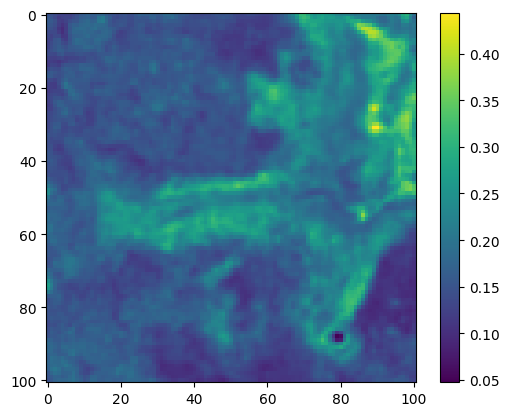

In [ ]:
for i in range(0, 1):
    plt.imshow(b12_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## View as RGB

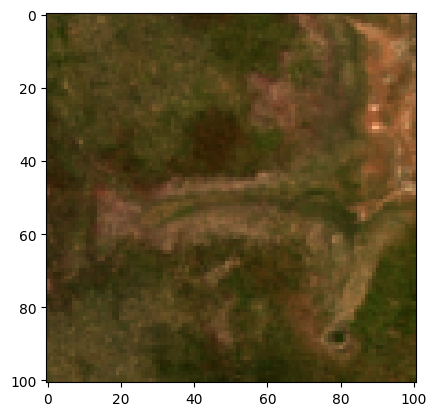

In [ ]:
# Assuming b4_tens_norm, b3_tens_norm, and b2_tens_norm are your tensors
rgb_image = torch.stack([b4_tens, b3_tens, b2_tens], dim=-1)

# Convert to NumPy and clip values to [0, 1] for display
rgb_image_np = rgb_image[0].cpu().numpy()

# Normalize to the range [0, 1] for display
rgb_image_np = (rgb_image_np - rgb_image_np.min()) / (rgb_image_np.max() - rgb_image_np.min())

# Display the image
plt.imshow(rgb_image_np)
plt.show()

## Presence records - target of model

In [ ]:
# Using rasterio
with rasterio.open(pres_path) as pres:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    pres_stack = pres.read([i for i in range(1, pres.count + 1)])

print(pres_stack.shape)
print(type(pres_stack))

(5145, 101, 101)
<class 'numpy.ndarray'>


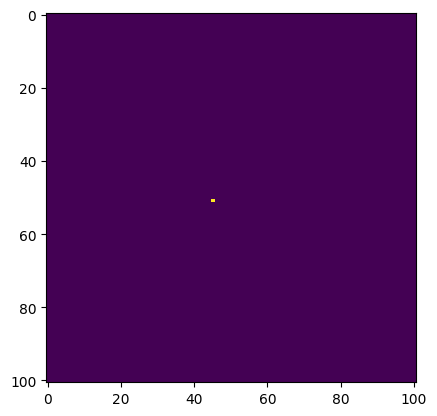

In [ ]:
for i in range(0, 1):
    plt.imshow(pres_stack[i])
    plt.show()

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cuda device


### Combine the spatial layers into channels

In [ ]:
# Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
# combined_stack = torch.stack([ndvi_tens_norm, canopy_tens_norm, herby_tens_norm, slope_tens_norm], dim=1)

# use sentinel-2 bands
combined_stack = torch.stack([b1_tens_norm, b2_tens_norm, b3_tens_norm, b4_tens_norm,
                              b5_tens_norm, b6_tens_norm, b7_tens_norm, b8_tens_norm,
                              b8a_tens_norm, b9_tens_norm, b11_tens_norm, b12_tens_norm,
                              slope_tens_norm], dim=1)
combined_stack
print(combined_stack.shape)

torch.Size([5145, 13, 101, 101])


## Defining data sets and data loaders

### Creating a dataset class

In [ ]:
class buffalo_data(Dataset):

    def __init__(self):
        # data loading
        self.spatial_data_x = combined_stack

        # the scalar data that will be converted to grid data and added to the spatial covariates for CNN components
        self.scalar_to_grid_data = torch.from_numpy(buffalo_df[['hour_t2_sin', 'hour_t2_cos', 'yday_t2_sin', 'yday_t2_cos']].values).float()

        # self.bearing_x = torch.from_numpy(buffalo_df[['bearing']].values).float()
        self.bearing_x = torch.from_numpy(buffalo_df[['bearing_tm1']].values).float()

        self.target = torch.tensor(pres_stack)

        self.n_samples = self.spatial_data_x.shape[0]

    def __len__(self):
        # len(data)
        return self.n_samples

    def __getitem__(self, index):
        # allows for indexing of the dataset
        return self.spatial_data_x[index], self.scalar_to_grid_data[index], self.bearing_x[index], self.target[index]


In [ ]:
# torch.from_numpy(buffalo_df['bearing'].values).float()
torch.from_numpy(buffalo_df['bearing_tm1'].values).float()

tensor([ 0.0000, -2.9995,  0.1609,  ...,  2.6724, -1.9790,  2.7153])

In [ ]:
dataset = buffalo_data()
first_data = dataset[:]
# print(first_data)
print(dataset.n_samples)

features1, features2, features3, labels = first_data
print(features1.shape)
print(features2.shape)
print(features3.shape)
print(labels.shape)

# print(features1)
# print(features2)
# print(features3)
# print(labels)

# dataset.shape
# print(dataset[0,:])

5145
torch.Size([5145, 13, 101, 101])
torch.Size([5145, 4])
torch.Size([5145, 1])
torch.Size([5145, 101, 101])


### Split into training, validation and test sets

In [ ]:
training_split = 0.8
validation_split = 0.1
test_split = 0.1

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, [training_split, validation_split, test_split])
print(len(dataset_train))
print(len(dataset_val))
print(len(dataset_test))

4117
514
514


### Create dataloaders

In [ ]:
bs = 32 # batch size
dataloader_train = DataLoader(dataset=dataset_train, batch_size=bs, shuffle=True)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=bs, shuffle=True)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=bs, shuffle=True)

In [ ]:
# Display image and label.
features1, features2, features3, labels = next(iter(dataloader_train))
print(f"Feature 1 batch shape: {features1.size()}")
print(f"Feature 2 batch shape: {features2.size()}")
print(f"Feature 3 batch shape: {features3.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature 1 batch shape: torch.Size([32, 13, 101, 101])
Feature 2 batch shape: torch.Size([32, 4])
Feature 3 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])


# Define the model

In [ ]:
class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)


class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        # self.kernel_size_mp = params.kernel_size_mp
        # self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    def forward(self, x):
        # print("Shape before squeeze:", self.conv2d(x).shape)
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
        # print("Shape before logsumexp:", conv2d_spatial.shape)

        # normalise before combining with the movement grid
        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)

        # conv2d_spatial = conv2d_spatial/torch.sum(conv2d_spatial)
        return conv2d_spatial


class FCN_block_all_habitat(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_habitat, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.image_dim * self.image_dim)
        )

    def forward(self, x):
        return self.ffn(x)


class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )

    def forward(self, x):
        return self.ffn(x)

class FCN_block_nonspatial(nn.Module):
    def __init__(self, params):
        super(FCN_block_nonspatial, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_nonspatial = params.dense_dim_in_nonspatial
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_nonspatial, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_out)
        )

    def forward(self, x):
        return self.ffn(x)



##################################################
# Mixture of two Gamma and von Mises distributions with the von Mises mu parameters allowed to vary
##################################################

class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
        # self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.bearing_layer = torch.from_numpy(np.arctan2(self.center - y, x - self.center))
        self.device = params.device


    # Gamma desnities for the mixture distribution
    def gamma_density(self, x, shape, scale):
        # Ensure all tensors are on the same device as x
        shape = shape.to(x.device)
        scale = scale.to(x.device)
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

    # von Mises densities for the mixture distribution
    def vonmises_density(self, x, kappa, vm_mu):
        # Ensure all tensors are on the same device as x
        kappa = kappa.to(x.device)
        vm_mu = vm_mu.to(x.device)
        return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


    def forward(self, x, bearing):

        # parameters of the first mixture distribution
        gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape1 = gamma_shape1.permute(2, 0, 1)

        gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale1 = gamma_scale1.permute(2, 0, 1)

        gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight1 = gamma_weight1.permute(2, 0, 1)

        # parameters of the second mixture distribution
        gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
        gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape2 = gamma_shape2.permute(2, 0, 1)

        gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
        gamma_scale2 = gamma_scale2 * 500 ### to transform the scale parameter to be near 1
        gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale2 = gamma_scale2.permute(2, 0, 1)

        gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
        gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight2 = gamma_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        gamma_weights = torch.stack([gamma_weight1, gamma_weight2], dim=0)
        gamma_weights = torch.nn.functional.softmax(gamma_weights, dim=0)
        gamma_weight1 = gamma_weights[0]
        gamma_weight2 = gamma_weights[1]

        # calculation of Gamma densities
        gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1).to(device)
        gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2).to(device)

        # combining both densities to create a mixture distribution using logsumexp
        logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
        gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))

        # normalise the gamma weights so they sum to 1
        # gamma_density_layer = gamma_density_layer - torch.logsumexp(gamma_density_layer, dim = (1, 2), keepdim = True)

        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))


        ## Von Mises Distributions

        # calculate the new bearing from the turning angle
        # takes in the bearing from the previous step and adds the turning angle
        bearing_new1 = x[:, 6] + bearing[:, 0]
        # bearing_new1 = 0.0 + bearing[:, 0]

        # print('Bearing.shape ', bearing.shape)
        # print('Bearing[:, 0].shape ', bearing[:, 0].shape)
        # print('Bearing[:, 0] ', bearing[:, 0])
        # the new bearing becomes the mean of the von Mises distribution
        # the estimated parameter [x:, 7] is the turning angle of the next step
        # which is always in reference to the input bearing
        vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
        vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

        # parameters of the first von Mises distribution
        vonmises_kappa1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

        vonmises_weight1 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
        vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

        # vm_mu and weight for the second von Mises distribution
        bearing_new2 = x[:, 9] + bearing[:, 0]
        # bearing_new2 = torch.pi + bearing[:, 0]
        # bearing_new2 = -torch.pi + bearing[:, 0]

        vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
        vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

        # parameters of the second von Mises distribution
        vonmises_kappa2 = torch.exp(x[:, 10]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

        vonmises_weight2 = torch.exp(x[:, 11]).unsqueeze(0).unsqueeze(0)
        vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        vonmises_weights = torch.stack([vonmises_weight1, vonmises_weight2], dim=0)
        vonmises_weights = torch.nn.functional.softmax(vonmises_weights, dim=0)
        vonmises_weight1 = vonmises_weights[0]
        vonmises_weight2 = vonmises_weights[1]

        # calculation of von Mises densities
        vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1).to(device)
        vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2).to(device)

        # combining both densities to create a mixture distribution using the logsumexp trick
        logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
        vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # normalise so the densities sum to 1 when exponentiated
        # vonmises_density_layer = vonmises_density_layer - torch.logsumexp(vonmises_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # combining the two distributions
        movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale
        # print('Movement grid ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        # normalise before combining with the habitat predictions
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)

        # print('Movement grid norm ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        return movement_grid


class Scalar_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Scalar_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):
        num_scalars = x.shape[1]
        scalar_map = x.view(x.shape[0], num_scalars, 1, 1).expand(x.shape[0], num_scalars, self.image_dim, self.image_dim)
        return scalar_map


class Vector_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Vector_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):
        x_unnorm = x.reshape(x.shape[0], self.image_dim, self.image_dim)
        x = x_unnorm - torch.logsumexp(x_unnorm, dim = (1, 2), keepdim = True)
        return x

        # x = x_unnorm/torch.sum(x_unnorm)
        # return x


class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()
        # self.conv_habitat = Conv2d_block(params)
        # self.fcn_habitat_all = FCN_block_all_habitat(params)
        # self.fcn_habitat_nonspatial = FCN_block_nonspatial(params)
        # self.habitat_grid_output = Vector_to_Grid_Block(params)

        self.scalar_grid_output = Scalar_to_Grid_Block(params)
        self.conv_habitat = Conv2d_block_spatial(params)

        self.conv_movement = Conv2d_block_toFC(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        self.fcn_movement_nonspatial = FCN_block_nonspatial(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device

    def forward(self, x):
        spatial_data_x = x[0]
        scalars_to_grid = x[1]
        # additional_data_x = x[2]
        bearing_x = x[2]

        # conv_habitat = self.conv_habitat(spatial_data_x)
        # covariates_habitat = self.fcn_habitat_nonspatial(additional_data_x)
        # all_predictors_habitat = torch.cat([conv_habitat, covariates_habitat], dim = 1)
        # # print(f"Shape after concatenation: {all_predictors_habitat.shape}")  # Debugging print
        # output_habitat = self.fcn_habitat_all(all_predictors_habitat)
        # output_habitat = self.habitat_grid_output(output_habitat)

        # SCALAR GRIDS
        scalar_grids = self.scalar_grid_output(scalars_to_grid)
        all_spatial = torch.cat([spatial_data_x, scalar_grids], dim = 1)
        # print(f"Shape after scalar grid: {all_spatial.shape}")  # Debugging print


        # HABITAT SELECTION
        output_habitat = self.conv_habitat(all_spatial)
        # print(f"Shape after CNN habitat: {output_habitat.shape}")  # Debugging print


        # MOVEMENT
        conv_movement = self.conv_movement(all_spatial)
        # print(f"Shape after CNN to FC movement: {conv_movement.shape}")  # Debugging print

        # covariates_movement = self.fcn_movement_nonspatial(additional_data_x)
        # print(f"Shape after fcn_movement_nonspatial: {covariates_movement.shape}")  # Debugging print

        # all_predictors_movement = torch.cat([conv_movement, covariates_movement], dim = 1)
        # print(f"Shape after torch.cat([conv_movement, covariates_movement], dim = 1): {all_predictors_movement.shape}")  # Debugging print

        output_movement = self.fcn_movement_all(conv_movement)
        # print(f"Shape after fcn_movement_all: {output_movement.shape}")  # Debugging print
        output_movement = self.movement_grid_output(output_movement, bearing_x)
        # print(f"Shape after CNN movement: {output_movement.shape}")  # Debugging print

        # combine the habitat and movement predictions
        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output


class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dim_in_nonspatial_to_grid = dict_params["dim_in_nonspatial_to_grid"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Instantiate the model

In [ ]:
num_spatial_covs = 13

params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": num_spatial_covs + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

## Testing the scalar to grid function

torch.Size([32, 4])
tensor([ 0.7071,  0.7071, -0.2885,  0.9575])
torch.Size([32, 4, 101, 101])


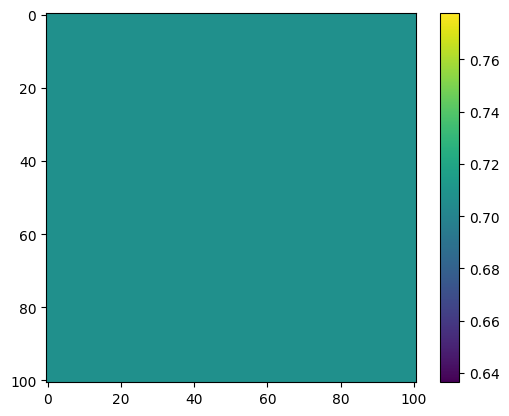

In [ ]:
# test_scalars = torch.tensor([[2.0, 1.0]], device=device)
test_data = x1, x2, x3, labels = next(iter(dataloader_test))
test_scalars = x2
print(test_scalars.shape)
print(test_scalars[0,:])

test_block = Scalar_to_Grid_Block(params)
scalar_maps = test_block(test_scalars)
# print(scalar_maps)
print(scalar_maps.shape)

# should show the same value across the grid
plt.imshow(scalar_maps[0, 0])
plt.colorbar()
plt.show()

### Create some random covariates to test the model

In [ ]:
test_batch = 1
x1 = (torch.rand(test_batch, num_spatial_covs, 101, 101, device=device)) #spatial data
x2 = (torch.rand(test_batch, 4, device=device)) #other scalar covariates
x3 = (torch.rand(test_batch, 1, device=device)) # bearing
# x4 = (torch.rand(test_batch, 1, device=device)) #bearing
# y = (torch.rand(1, 1, 101, 101, device=device)) #spatial data
print(x2)
print(x3)
# print(x4)

# plot the results of the movement density as an image
# plt.imshow(x1.detach().cpu().numpy()[0, 0, :,:])
# plt.colorbar()
# plt.show()

# synth_ds = TensorDataset(x1, x2, y)
# synth_dl = DataLoader(synth_ds, batch_size=1, shuffle=True)

tensor([[0.8891, 0.3829, 0.1849, 0.4119]], device='cuda:0')
tensor([[0.5874]], device='cuda:0')


torch.Size([1, 101, 101, 2])


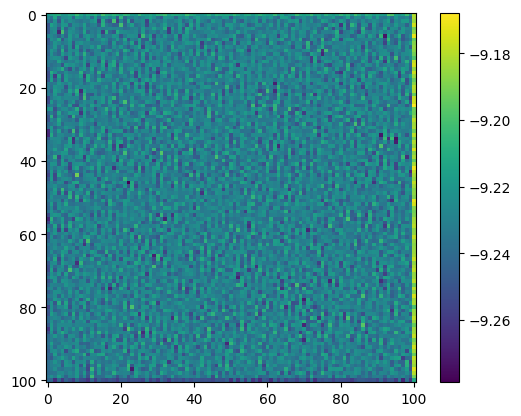

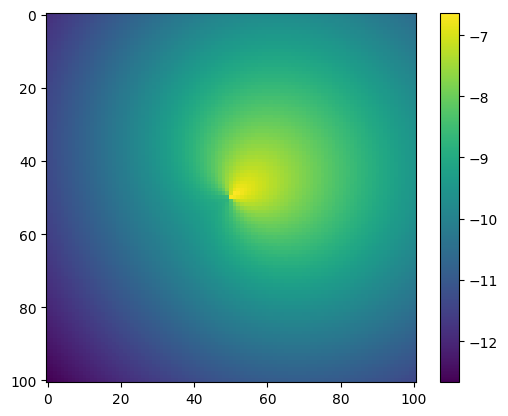

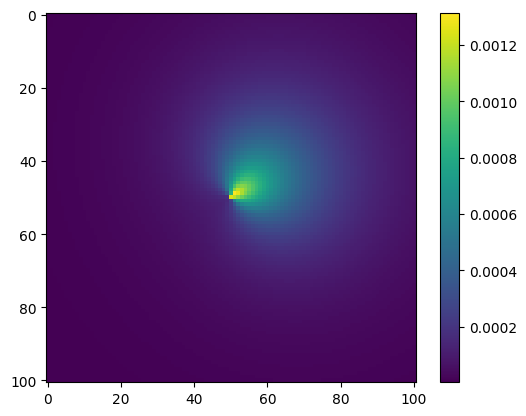

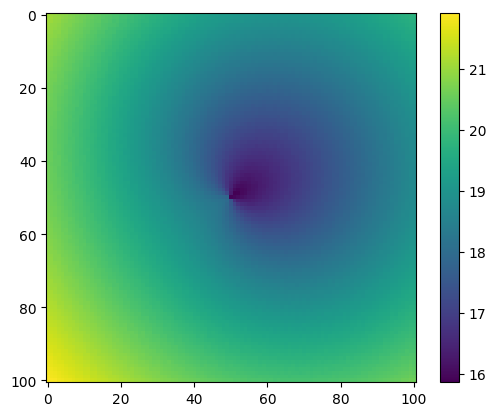

In [ ]:
#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# plot the results of the habitat density as an image
plt.imshow(test.detach().cpu().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

# plot the results of the movement density as an image
plt.imshow(test.detach().cpu().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

# plot the results of the exp movement density as an image
plt.imshow(np.exp(test.detach().cpu().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

test_cat = -1 * (test[:, :, :, 0] + test[:, :, :, 1])
# test_cat = torch.log(test[:, :, :, 0]*test[:, :, :, 1])
# test_cat = -1 * test[:, :, :, 0] * torch.exp(test[:, :, :, 1])

plt.imshow(test_cat.detach().cpu().numpy()[0,:,:])
plt.colorbar()
plt.show()

### Testing the movement parameter block with known Gamma and von Mises parameters

tensor([[[-11.1784, -11.1407, -11.1036,  ..., -10.9295, -10.9666, -11.0044],
         [-11.1288, -11.0908, -11.0535,  ..., -10.8794, -10.9168, -10.9550],
         [-11.0797, -11.0414, -11.0038,  ..., -10.8298, -10.8675, -10.9060],
         ...,
         [-11.0797, -11.0414, -11.0038,  ..., -10.8298, -10.8675, -10.9060],
         [-11.1288, -11.0908, -11.0535,  ..., -10.8794, -10.9168, -10.9550],
         [-11.1784, -11.1407, -11.1036,  ..., -10.9295, -10.9666, -11.0044]]],
       device='cuda:0', dtype=torch.float64)
torch.Size([1, 101, 101])


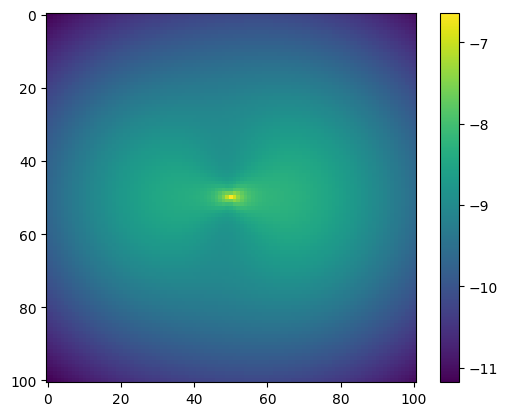

In [ ]:
test_bearing = torch.tensor([[0.0]], device=device)

test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass

# for single Gamma and von Mises distributions
# movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200/500), # gamma shape and scale
#                                              0.0, np.log(1.5)]], # von Mises mu and kappa
#                                            device=device), test_bearing)

# for the mixture
movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200), np.log(0.25), # gamma 1 - shape, scale and weight
                                             np.log(2.5), np.log(300/500), np.log(0.75), # gamma 2 - shape, scale and weight
                                             0.0, np.log(1), np.log(0.75),
                                             -np.pi, np.log(1.5), np.log(0.25)]], device=device), test_bearing)

# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)
print(movement_density.shape)

# plot the results of the movement density as an image
plt.imshow(movement_density.detach().cpu().numpy()[0])
plt.colorbar()
plt.show()

## Loss function and optimizer

In [ ]:
# Custom loss function to work with the two heatmaps that the model outputs

class negativeLogLikeLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(negativeLogLikeLoss, self).__init__()
        assert reduction in ['mean', 'sum', 'none'], "reduction should be 'mean', 'sum', or 'none'"
        self.reduction = reduction  # Assign reduction to self.reduction

    def forward(self, predict, target):
        predict_prod = predict[:, :, :, 0] + predict[:, :, :, 1]          # elementwise summation of the two heatmaps - for log-densities
        # predict_prod = predict[:, :, :, 0]*predict[:, :, :, 1]          # elementwise product of the two heatmaps
        # predict_prod = predict_prod/torch.sum(predict_prod)             # normalise the product of the two heatmaps
        # negLogLike = -1*(predict_prod * target)

        # Check for NaNs in the product
        if torch.isnan(predict_prod).any():
            print("NaNs detected in predict_prod")
            print("predict_prod:", predict_prod)
            raise ValueError("NaNs detected in predict_prod")

        # predict_prod = predict_prod / torch.sum(predict_prod)  # normalise the product of the two heatmaps

        # Check for NaNs after normalization
        # if torch.isnan(predict_prod).any():
        #     print("NaNs detected after normalization")
        #     print("predict_prod:", predict_prod)
        #     raise ValueError("NaNs detected after normalization")

        negLogLike = -1 * (predict_prod * target)
        # negLogLike = -1 * torch.log(predict_prod * target)

        # Check for NaNs in the negative log likelihood
        if torch.isnan(negLogLike).any():
            print("NaNs detected in negLogLike")
            print("negLogLike:", negLogLike)
            raise ValueError("NaNs detected in negLogLike")

        if self.reduction == 'mean':
            return torch.mean(negLogLike)
        elif self.reduction == 'sum':
            return torch.sum(negLogLike)
        elif self.reduction == 'none':
            return negLogLike
        return negLogLike

### Early stopping code

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Instantiate the model

In [ ]:
params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

# # save the model structure
# torch.save(model, 'CNN_model_global.pth')

learning_rate = 1e-4
loss_fn = negativeLogLikeLoss(reduction='mean')

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# path to save the model weights
path_save_weights = f'../buffalo_local_layers_id/model_checkpoints/checkpoint_CNN_S2_slope_buffalo{buffalo_id}_{today_date}.pt'

optimiser = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.1, patience=5)
early_stopping = EarlyStopping(patience=10, verbose=True, path = path_save_weights) # , delta=early_stopping_delta

torch.Size([1, 101, 101, 2])


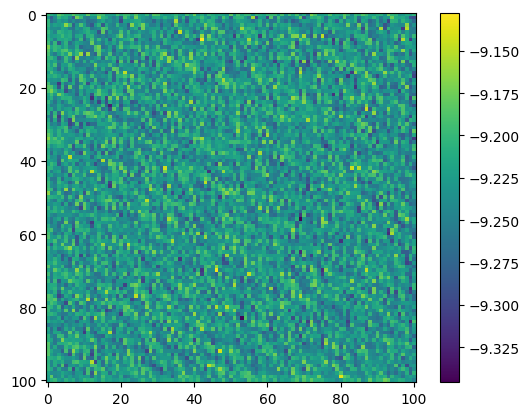

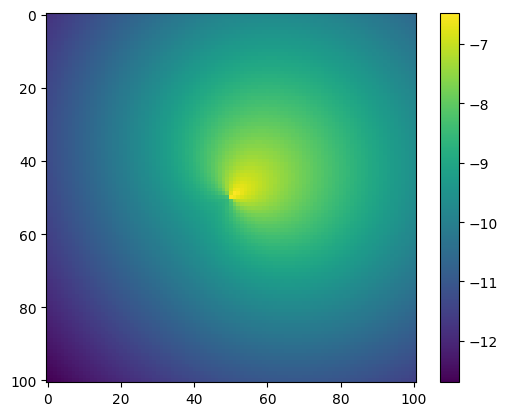

0.9999999999999998


In [ ]:
# 1. Set the model in evaluation mode
model.eval()

#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# # plot the results of the habitat density as an image
plt.imshow(test.detach().cpu().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

# # plot the results of the movement density as an image
plt.imshow(test.detach().cpu().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

print(np.sum(np.exp(test.detach().cpu().numpy()[0,:,:,1])))

# test_cat = test[:, :, :, 0]*test[:, :, :, 1]
# test_cat = test_cat/torch.sum(test_cat)
# print(test_cat.shape)

# test_cat = -1 * torch.log(test[:, :, :, 0]*test[:, :, :, 1] )
# print(test_cat.shape)

# plt.imshow(test_cat.detach().numpy()[0,:,:])
# plt.colorbar()
# plt.show()

## Training loop

In [ ]:
def train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler):
    size = len(dataloader_train.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()

    epoch_loss = 0.0
    # val_loss = 0.0
    # num_batches = len(dataloader_test)

    for batch, (x1, x2, x3, y) in enumerate(dataloader_train):

        # Move input tensors to the GPU if available
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        y = y.to(device)

        # calculate the loss
        loss = loss_fn(model((x1, x2, x3)), y)
        epoch_loss += loss

        # Backpropagation
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), batch * bs + len(x1)
            print(f"loss: {loss:>15f}  [{current:>5d}/{size:>5d}]")

    # # Model validation to assess the learning rate
    # # Set the model to evaluation mode for the validation dataset
    # model.eval()
    # with torch.no_grad():
    #     for x1, x2, y in dataloader_val:
    #         val_loss += loss_fn(model((x1, x2)), y)

    # scheduler.step(val_loss)

    # val_loss /= num_batches
    # print(f"\nAvg validation loss: {val_loss:>15f}")
    # print(f"Learning rate: {scheduler.get_last_lr()}")
    # # print(f"Epoch {t+1}, Total loss: {epoch_loss:>15f}")
    # return val_loss


def test_loop(dataloader_test, model, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    size = len(dataloader_test.dataset)
    num_batches = len(dataloader_test)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for x1, x2, x3, y in dataloader_test:

            # Move input tensors to the GPU if available
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            test_loss += loss_fn(model((x1, x2, x3)), y)

    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Avg test loss: {test_loss:>15f} \n")

## Train the model

In [ ]:
epochs = 100

for t in range(epochs):

    val_loss = 0.0
    num_batches = len(dataloader_test)

    print(f"Epoch {t+1}\n-------------------------------")

    train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler)

    # Model validation to assess the learning rate
    # Set the model to evaluation mode for the validation dataset
    model.eval()
    with torch.no_grad():
        for x1, x2, x3, y in dataloader_val:

            # Move input tensors to the GPU if available
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            val_loss += loss_fn(model((x1, x2, x3)), y)
    scheduler.step(val_loss)

    val_loss /= num_batches
    print(f"\nAvg validation loss: {val_loss:>15f}")
    print(f"Learning rate: {scheduler.get_last_lr()}")
    # print(f"Epoch {t+1}, Total loss: {epoch_loss:>15f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        #load the optimal model weights
        model.load_state_dict(torch.load(path_save_weights))
        test_loop(dataloader_test, model, loss_fn)
        break
    else:
        model.eval()
        print("\n")

    # test_loop(dataloader_test, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss:        0.001667  [   32/ 4117]
loss:        0.001709  [  192/ 4117]
loss:        0.001662  [  352/ 4117]
loss:        0.001631  [  512/ 4117]
loss:        0.001605  [  672/ 4117]
loss:        0.001598  [  832/ 4117]
loss:        0.001579  [  992/ 4117]
loss:        0.001595  [ 1152/ 4117]
loss:        0.001554  [ 1312/ 4117]
loss:        0.001554  [ 1472/ 4117]
loss:        0.001607  [ 1632/ 4117]
loss:        0.001513  [ 1792/ 4117]
loss:        0.001552  [ 1952/ 4117]
loss:        0.001541  [ 2112/ 4117]
loss:        0.001522  [ 2272/ 4117]
loss:        0.001491  [ 2432/ 4117]
loss:        0.001538  [ 2592/ 4117]
loss:        0.001461  [ 2752/ 4117]
loss:        0.001600  [ 2912/ 4117]
loss:        0.001619  [ 3072/ 4117]
loss:        0.001479  [ 3232/ 4117]
loss:        0.001462  [ 3392/ 4117]
loss:        0.001506  [ 3552/ 4117]
loss:        0.001420  [ 3712/ 4117]
loss:        0.001490  [ 3872/ 4117]
loss:        0.001501  [ 4032/ 4117

<ipython-input-75-33bef938d280>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_save_weights))


Avg test loss:        0.001449 

Done!


In [ ]:
print(model.state_dict())
# model.load_state_dict(torch.load(path_save_weights))
model.load_state_dict(torch.load(path_save_weights, map_location=torch.device('cpu')))

OrderedDict([('conv_habitat.conv2d.0.weight', tensor([[[[-0.1109, -0.0993,  0.0259],
          [-0.0600, -0.0346,  0.0011],
          [-0.1066, -0.1041, -0.0205]],

         [[-0.1417, -0.0405, -0.0347],
          [-0.1456, -0.0361, -0.0714],
          [-0.1584, -0.1154,  0.0442]],

         [[-0.1537,  0.0036, -0.0323],
          [-0.1096, -0.1318,  0.0041],
          [-0.1483, -0.0738, -0.0013]],

         [[-0.1116, -0.0110,  0.0483],
          [-0.0386, -0.0160,  0.1250],
          [-0.0423,  0.0563,  0.0507]],

         [[-0.0901, -0.0123,  0.1328],
          [-0.0003,  0.1012,  0.0497],
          [-0.0289, -0.0109,  0.0600]],

         [[ 0.0731,  0.0288,  0.0707],
          [ 0.0746, -0.0139,  0.0010],
          [-0.0104,  0.0472, -0.0840]],

         [[ 0.0677,  0.0032,  0.0740],
          [ 0.0396,  0.0549,  0.0558],
          [ 0.0407, -0.0099, -0.0412]],

         [[ 0.0499,  0.0467, -0.0273],
          [ 0.0416,  0.0237,  0.0157],
          [-0.0042,  0.0637, -0.0048]],

  

<ipython-input-76-b9c49317c6d3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_save_weights, map_location=torch.device('cpu')))


<All keys matched successfully>

## View model outputs

### Run model forward

Feature x1 batch shape: torch.Size([32, 13, 101, 101])
Feature x2 batch shape: torch.Size([32, 4])
Feature x3 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])
[-0.9659258   0.25881904 -0.44822934  0.8939186 ]
18.99999963318935
337.99999604700537
-2.2754316


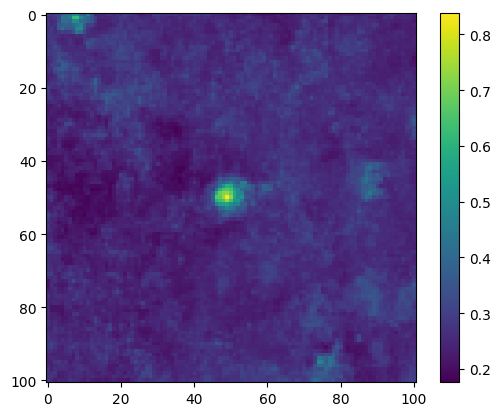

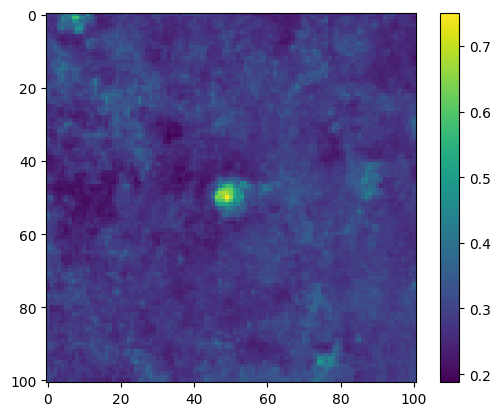

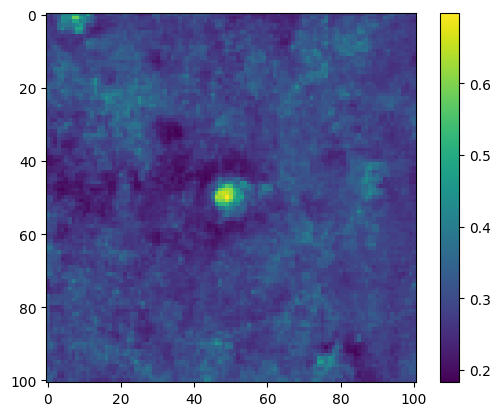

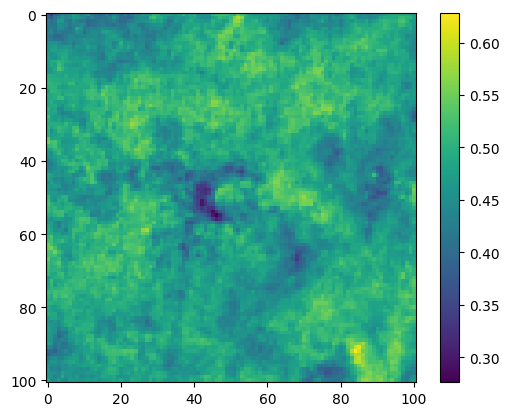

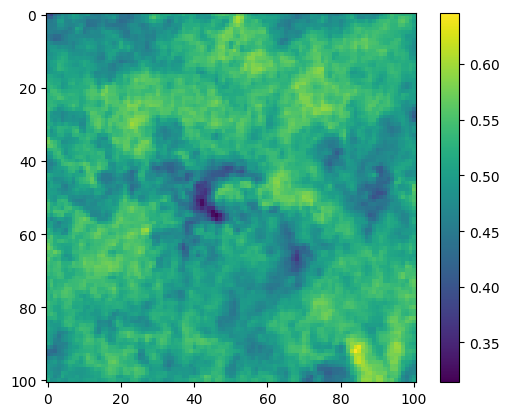

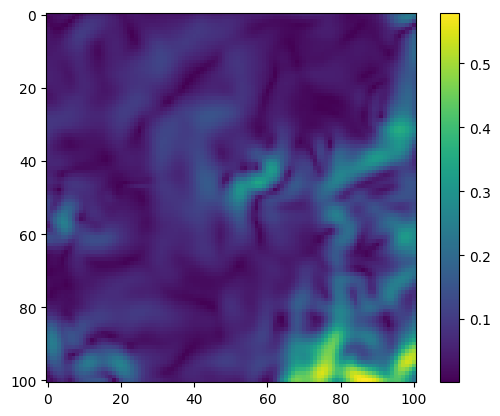

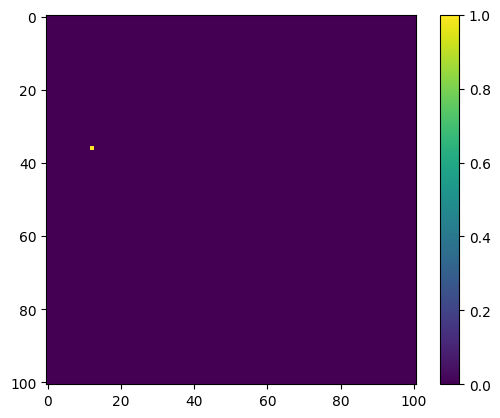

torch.Size([32, 101, 101, 2])


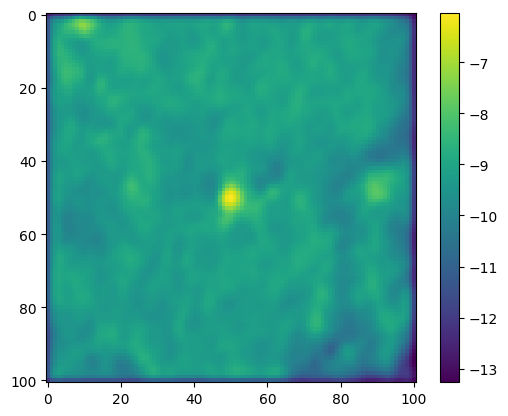

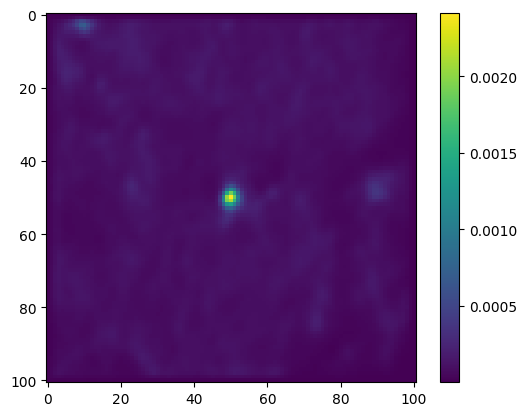

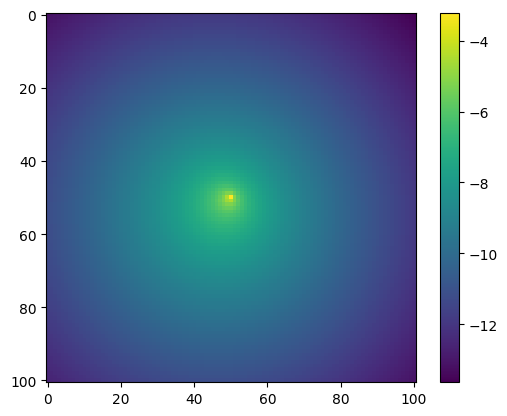

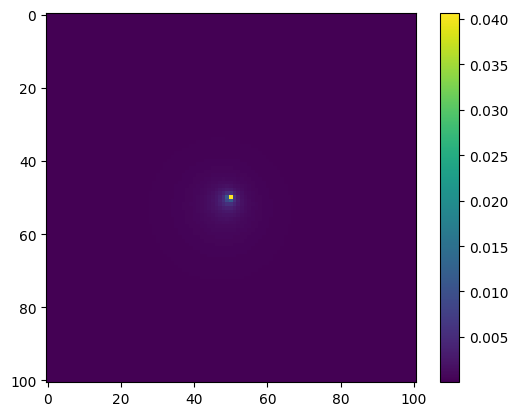

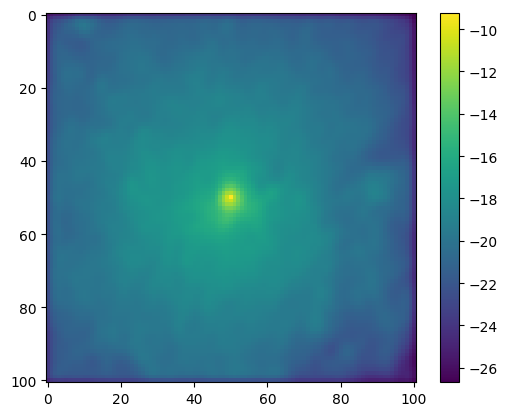

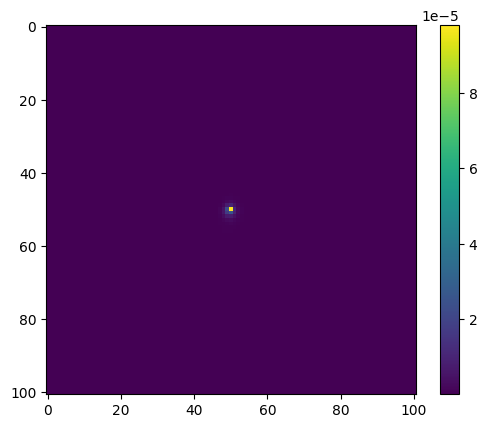

In [ ]:
# 1. Set the model in evaluation mode
model.eval()

# Display image and label.
x1, x2, x3, labels = next(iter(dataloader_test))
print(f"Feature x1 batch shape: {x1.size()}")
print(f"Feature x2 batch shape: {x2.size()}")
print(f"Feature x3 batch shape: {x3.size()}")
# print(f"Feature x4 batch shape: {x3.size()}")
print(f"Labels batch shape: {labels.size()}")

print(x2.detach().numpy()[0,:])

# Pull out the scalars
hour_t2_sin = x2.detach().numpy()[0,0]
hour_t2_cos = x2.detach().numpy()[0,1]
yday_t2_sin = x2.detach().numpy()[0,2]
yday_t2_cos = x2.detach().numpy()[0,3]
# bearing_sin = x2.detach().numpy()[0,4]
# bearing_cos = x2.detach().numpy()[0,5]
bearing = x3.detach().numpy()[0,0]

def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (12 * theta) / np.pi % 24
    return hour

hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
print(hour_t2)

def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi)  % 365
    return yday

yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
print(yday_t2)

# def recover_bearing(bearing_sin, bearing_cos):
#     # Calculate the angle (bearing) in radians
#     bearing = np.arctan2(bearing_sin, bearing_cos)
#     # Convert bearing from radians to degrees
#     bearing_degrees = np.degrees(bearing) % 360
#     return bearing_degrees

# bearing = recover_bearing(bearing_sin, bearing_cos)
print(bearing)

# Move input tensors to the GPU if available
x1 = x1.to(device)
x2 = x2.to(device)
x3 = x3.to(device)

# print(loss_fn(model((x1, x2, x3)), labels))

# plot the covariates
# plt.imshow(x1.detach().cpu().numpy()[0,0,:,:])
# plt.colorbar()
# plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,1,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,2,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,3,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,7,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,8,:,:])
plt.colorbar()
plt.show()

plt.imshow(x1.detach().cpu().numpy()[0,12,:,:])
plt.colorbar()
plt.show()

# plot the target
plt.imshow(labels.detach().cpu().numpy()[0,:,:])
plt.colorbar()
plt.show()

#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# print(np.sum(np.exp(test.detach().numpy()[0,:,:,0])))

# plot the results of the habitat density as an image - in log scale
plt.imshow(test.detach().cpu().numpy()[0,:,:,0])
# plt.imshow(np.exp(test.detach().numpy()[0,:,:,0]))
plt.colorbar()
plt.show()

# plot the results of the habitat density as an image - as probabilities
# plt.imshow(test.detach().numpy()[0,:,:,0])
plt.imshow(np.exp(test.detach().cpu().numpy()[0,:,:,0]))
plt.colorbar()
plt.show()

# print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

# plot the results of the movement density as an image - in log scale
plt.imshow(test.detach().cpu().numpy()[0,:,:,1])
# plt.imshow(np.exp(test.detach().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

# plot the results of the movement density as an image - as probabilities
# plt.imshow(test.detach().numpy()[0,:,:,1])
plt.imshow(np.exp(test.detach().cpu().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

# results of the habitat and movement densities
# log-scale
test_cat = test[0, :, :, 0] + test[0, :, :, 1]
plt.imshow(test_cat.detach().cpu().numpy()[:,:])
plt.colorbar()
plt.show()

# exponentiated
test_cat = torch.exp(test[0, :, :, 0] + test[0, :, :, 1])
plt.imshow(test_cat.detach().cpu().numpy()[:,:])
plt.colorbar()
plt.show()

## Displaying as RGB image

In [ ]:
# 1. Set the model in evaluation mode
model.eval()

for i in range(0, 5):

  # Display image and label.
  x1, x2, x3, labels = next(iter(dataloader_test))
  print(f"Feature x1 batch shape: {x1.size()}")
  print(f"Feature x2 batch shape: {x2.size()}")
  print(f"Feature x3 batch shape: {x3.size()}")
  print(f"Feature x4 batch shape: {x3.size()}")
  print(f"Labels batch shape: {labels.size()}")

  print(x2.detach().numpy()[0,:])

  # Pull out the scalars
  hour_t2_sin = x2.detach().numpy()[0,0]
  hour_t2_cos = x2.detach().numpy()[0,1]
  yday_t2_sin = x2.detach().numpy()[0,2]
  yday_t2_cos = x2.detach().numpy()[0,3]
  bearing = x3.detach().numpy()[0,0]

  hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
  hour_t2_integer = int(hour_t2)  # Convert to integer
  print(f'Hour: {hour_t2_integer}')

  yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
  yday_t2_integer = int(yday_t2)  # Convert to integer
  print(f'Day of the year: {yday_t2_integer}')

  bearing_degrees = np.degrees(bearing) % 360
  bearing_degrees = round(bearing_degrees, 1)  # Round to 2 decimal places
  bearing_degrees = int(bearing_degrees)  # Convert to integer
  print(f'Bearing (radians): {bearing}')
  print(f'Bearing (degrees): {bearing_degrees}')

  # plot the covariates
  blue_layer = x1.detach().cpu().numpy()[0,1,:,:]
  green_layer = x1.detach().cpu().numpy()[0,2,:,:]
  red_layer = x1.detach().cpu().numpy()[0,3,:,:]

  # Return to natural scale
  blue_layer = blue_layer * (b2_max.cpu().numpy() - b2_min.cpu().numpy()) + b2_min.cpu().numpy()
  green_layer = green_layer * (b3_max.cpu().numpy() - b3_min.cpu().numpy()) + b3_min.cpu().numpy()
  red_layer = red_layer * (b4_max.cpu().numpy() - b4_min.cpu().numpy()) + b4_min.cpu().numpy()

  # Stack and display
  rgb_image_np = np.stack([red_layer, green_layer, blue_layer], axis=-1)

  # Normalize to the range [0, 1] for display
  rgb_image_np = (rgb_image_np - rgb_image_np.min()) / (rgb_image_np.max() - rgb_image_np.min())

  # plt.imshow(rgb_image_np)
  # plt.show()

  # slope
  # plt.imshow(x1.detach().cpu().numpy()[0,12,:,:])
  # plt.colorbar()
  # plt.show()

  # plot the target
  # plt.imshow(labels.detach().cpu().numpy()[0,:,:])
  # plt.colorbar()
  # plt.show()

  # Find the coordinates of the element that is 1
  target = labels.detach().cpu().numpy()[0,:,:]
  coordinates = np.where(target == 1)
  # Extract the coordinates
  row, column = coordinates[0][0], coordinates[1][0]
  print(f"The coordinates of the element that is 1 are (row, column): ({row}, {column})")


  # Run model

  # Move input tensors to the GPU if available
  x1 = x1.to(device)
  x2 = x2.to(device)
  x3 = x3.to(device)

  test = model((x1, x2, x3))
  print(test.shape)
  # print(test)

  # plot the results of the habitat density as an image
  hab_density = test.detach().cpu().numpy()[0,:,:,0]
  hab_density_exp = np.exp(hab_density)

  # Create the mask for x and y coordinates
  x_mask = np.ones_like(hab_density)
  y_mask = np.ones_like(hab_density)

  # mask out cells on the edges that affect the colour scale
  x_mask[:, :3] = -np.inf
  x_mask[:, 98:] = -np.inf
  y_mask[:3, :] = -np.inf
  y_mask[98:, :] = -np.inf

  hab_density_mask = hab_density * x_mask * y_mask
  hab_density_exp_mask = hab_density_exp * x_mask * y_mask

  # # plot the results of the habitat density as an image - in log scale
  # plt.imshow(hab_density_mask)
  # plt.colorbar()
  # plt.show()

  # # plot the results of the habitat density as an image - as probabilities
  # plt.imshow(hab_density_exp_mask)
  # plt.colorbar()
  # plt.show()

  # print(np.sum(np.exp(test.detach().numpy()[0,:,:,1])))

  # movement probability
  move_density = test.detach().cpu().numpy()[0,:,:,1]
  move_density_exp = np.exp(move_density)

  move_density_mask = move_density * x_mask * y_mask
  move_density_exp_mask = move_density_exp * x_mask * y_mask

  # # plot the results of the movement density as an image - in log scale
  # plt.imshow(move_density_mask)
  # plt.colorbar()
  # plt.show()

  # # plot the results of the movement density as an image - as probabilities
  # plt.imshow(move_density_exp_mask)
  # plt.colorbar()
  # plt.show()


  # next step probability
  step_density = test[0, :, :, 0] + test[0, :, :, 1]
  step_density = step_density.detach().cpu().numpy()
  step_density_exp = np.exp(step_density)

  step_density_mask = step_density * x_mask * y_mask
  step_density_exp_mask = step_density_exp * x_mask * y_mask

  # # results of the habitat and movement densities
  # # log-scale
  # plt.imshow(step_density_mask)
  # plt.colorbar()
  # plt.show()

  # # exponentiated
  # plt.imshow(step_density_exp_mask)
  # plt.colorbar()
  # plt.show()


  # Plot the subset
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))

  # Plot RGB
  im1 = axs[0, 0].imshow(rgb_image_np)
  axs[0, 0].set_title('Sentinel-2 RGB')
  # fig.colorbar(im1, ax=axs[0, 0], shrink=0.7)

  # # Plot target
  # im2 = axs[0, 1].imshow(labels.detach().cpu().numpy()[0,:,:], cmap='viridis')
  # axs[0, 1].set_title('Observed next step')
  # # fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

  # Plot slope
  im2 = axs[0, 1].imshow(x1.detach().cpu().numpy()[0,12,:,:], cmap='viridis')
  axs[0, 1].set_title('Slope')
  fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

  # Plot habitat selection
  im3 = axs[1, 0].imshow(hab_density_mask, cmap='viridis')
  axs[1, 0].set_title('Habitat selection log-probability')
  fig.colorbar(im3, ax=axs[1, 0], shrink=0.7)

  # # Movement density
  # im3 = axs[1, 0].imshow(move_density_mask, cmap='viridis')
  # axs[1, 0].set_title('Movement log-probability')
  # fig.colorbar(im3, ax=axs[0, 1], shrink=0.7)

  # Next-step probability
  im4 = axs[1, 1].imshow(step_density_mask, cmap='viridis')
  axs[1, 1].set_title('Next-step log-probability')
  fig.colorbar(im4, ax=axs[1, 1], shrink=0.7)

  filename_covs = f'../buffalo_local_layers_id/rgb_steps/s2_slope_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}.png'
  plt.tight_layout()
  plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
  plt.show()
  plt.close()  # Close the figure to free memory


Output hidden; open in https://colab.research.google.com to view.

### Adding hooks to check movement parameters

In [ ]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Print the intermediate output
print("Intermediate output shape:", intermediate_output[0].shape)
print("Intermediate output values:", intermediate_output[0][0])

# Remove hook
hook_handle.remove()

# gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]
gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]
# gamma_shape1, gamma_scale1, vonmises_mu1, vonmises_kappa1 = intermediate_output[0][0]


# Gamma 1 parameters
print("Gamma shape 1:", torch.exp(gamma_shape1))
print("Gamma scale 1:", torch.exp(gamma_scale1))
print("Gamma weight 1:", torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# Gamma 2 parameters
print("Gamma shape 2:", torch.exp(gamma_shape2))
print("Gamma scale 2:", torch.exp(gamma_scale2)*500)
print("Gamma weight 2:", torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# Von Mises 1 parameters
# print("Von Mises mu 1:", vonmises_mu1 % (2*np.pi))
print("Von Mises kappa 1:", torch.exp(vonmises_kappa1))
print("Von Mises weight 1:", torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))

# Von Mises 2 parameters
# print("Von Mises mu 2:", vonmises_mu2 % (2*np.pi))
print("Von Mises kappa 2:", torch.exp(vonmises_kappa2))
print("Von Mises weight 2:", torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))


Intermediate output shape: torch.Size([32, 12])
Intermediate output values: tensor([ 0.5389,  1.1857,  0.4089, -3.4108, -0.4617, -1.8975, -0.4292, -1.3728,
        -0.3129,  0.3111, -0.7425,  0.2803], device='cuda:0')
Gamma shape 1: tensor(1.7142, device='cuda:0')
Gamma scale 1: tensor(3.2729, device='cuda:0')
Gamma weight 1: tensor(0.9094, device='cuda:0')
Gamma shape 2: tensor(0.0330, device='cuda:0')
Gamma scale 2: tensor(315.0984, device='cuda:0')
Gamma weight 2: tensor(0.0906, device='cuda:0')
Von Mises kappa 1: tensor(0.2534, device='cuda:0')
Von Mises weight 1: tensor(0.3559, device='cuda:0')
Von Mises kappa 2: tensor(0.4759, device='cuda:0')
Von Mises weight 2: tensor(0.6441, device='cuda:0')


Plot the distributions

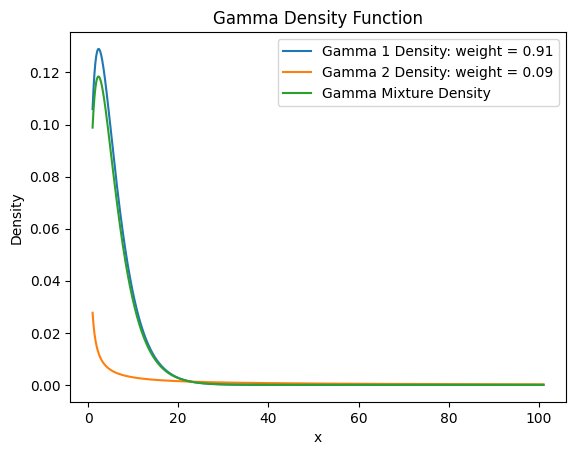

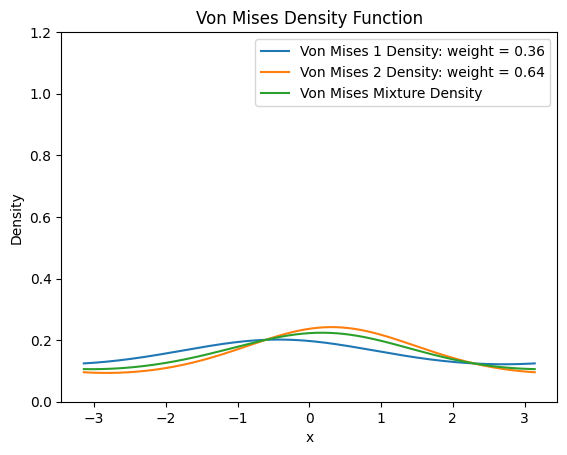

In [ ]:
# Gamma densities for the mixture distribution
def gamma_density(x, shape, scale):
    return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

# von Mises densities for the mixture distribution
def vonmises_density(x, kappa, vm_mu):
    return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


### Round the weight variables

# Gamma weights
gamma_weight1_recovered = torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight1 = round(gamma_weight1_recovered.item(), 2)
gamma_weight2_recovered = torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight2 = round(gamma_weight2_recovered.item(), 2)

# von Mises weights
vonmises_weight1_recovered = torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight1 = round(vonmises_weight1_recovered.item(), 2)
vonmises_weight2_recovered = torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight2 = round(vonmises_weight2_recovered.item(), 2)


# parameters of the Gamma mixture distributions
# Generate x values from 1 to 1000
x_values = torch.linspace(1, 101, 1000).to(device)
gamma1_density = gamma_density(x_values, torch.exp(gamma_shape1), torch.exp(gamma_scale1))
gamma2_density = gamma_density(x_values, torch.exp(gamma_shape2), torch.exp(gamma_scale2)*500)
gamma_mixture_density = gamma_weight1_recovered*torch.exp(gamma1_density) + gamma_weight2_recovered*torch.exp(gamma2_density)

# Move tensors to CPU and convert to NumPy arrays
x_values_np = x_values.cpu().numpy()
gamma1_density_np = np.exp(gamma1_density.cpu().numpy())  # Move to CPU before np.exp
gamma2_density_np = np.exp(gamma2_density.cpu().numpy())  # Move to CPU before np.exp
gamma_mixture_density_np = gamma_mixture_density.cpu().numpy()

# Plot the gamma density function
# plt.plot(x_values_np, gamma1_density_np, label='Gamma 1 Density')
plt.plot(x_values_np, gamma1_density_np, label=f'Gamma 1 Density: weight = {rounded_gamma_weight1}')
plt.plot(x_values_np, gamma2_density_np, label=f'Gamma 2 Density: weight = {rounded_gamma_weight2}')
plt.plot(x_values_np, gamma_mixture_density_np, label='Gamma Mixture Density')
# plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Gamma Density Function')
plt.legend()
plt.show()

# parameters of the von mises mixture distribution
# Generate x values from -pi to pi
x_values = torch.linspace(-np.pi, np.pi, 1000).to(device)
vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), vonmises_mu1)
vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), vonmises_mu2)
# vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), 0)
# vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), -torch.pi)
vonmises_mixture_density = vonmises_weight1_recovered*torch.exp(vonmises1_density) + vonmises_weight2_recovered*torch.exp(vonmises2_density)

# Move tensors to CPU and convert to NumPy arrays
x_values_np = x_values.cpu().numpy() # Move x_values to cpu
vonmises1_density_np = np.exp(vonmises1_density.cpu().numpy())  # Move to CPU before np.exp
vonmises2_density_np = np.exp(vonmises2_density.cpu().numpy())  # Move to CPU before np.exp
vonmises_mixture_density_np = vonmises_mixture_density.cpu().numpy() # Move vonmises_mixture_density to cpu

# Plot the von mises density function
# plt.plot(x_values_np, vonmises1_density_np, label='Von Mises 1 Density')
plt.plot(x_values_np, vonmises1_density_np, label=f'Von Mises 1 Density: weight = {rounded_vm_weight1}')
plt.plot(x_values_np, vonmises2_density_np, label=f'Von Mises 2 Density: weight = {rounded_vm_weight2}')
plt.plot(x_values_np, vonmises_mixture_density_np, label='Von Mises Mixture Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Von Mises Density Function')
plt.ylim(0, 1.2)  # Set the y-axis limits
plt.legend()
plt.show()

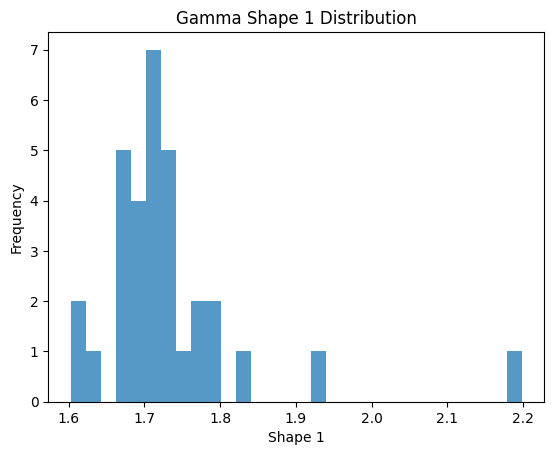

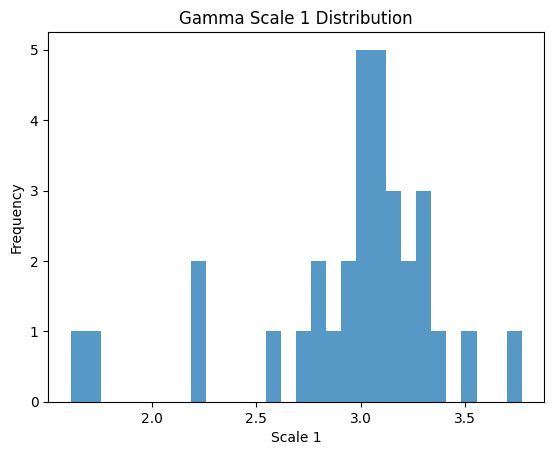

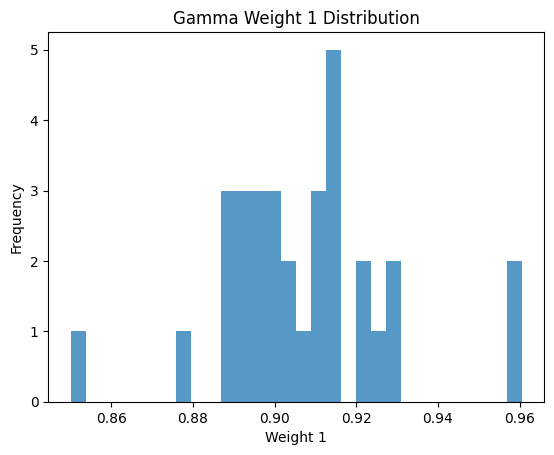

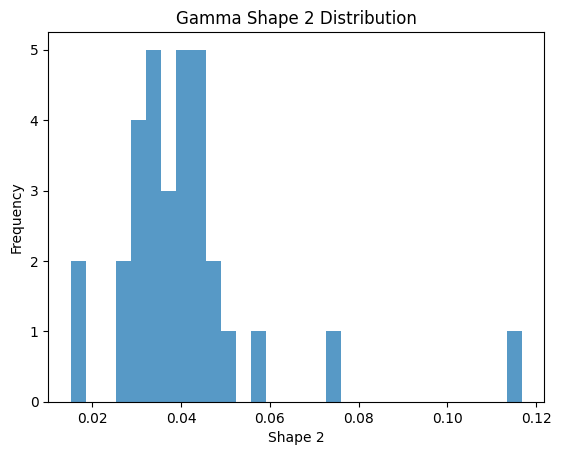

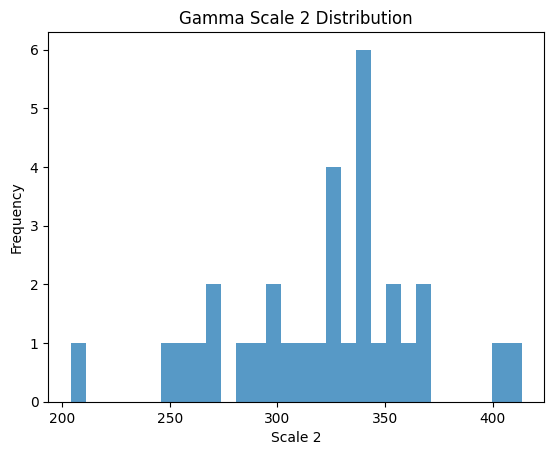

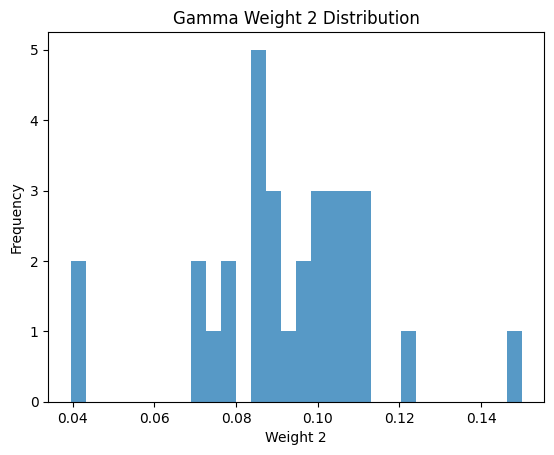

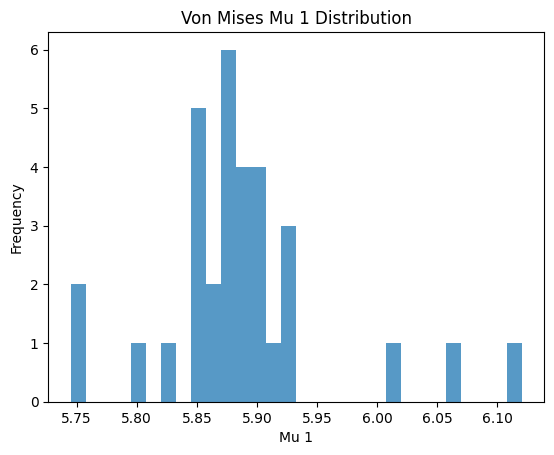

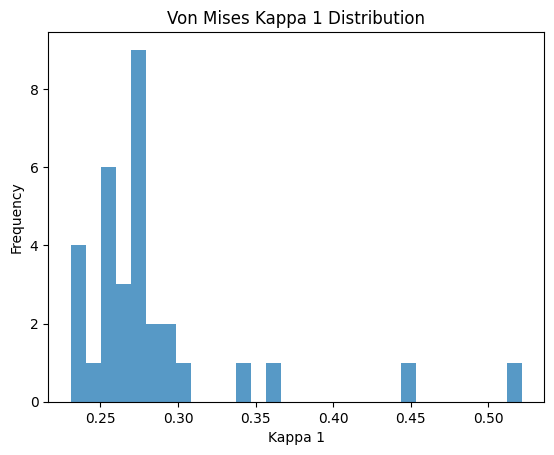

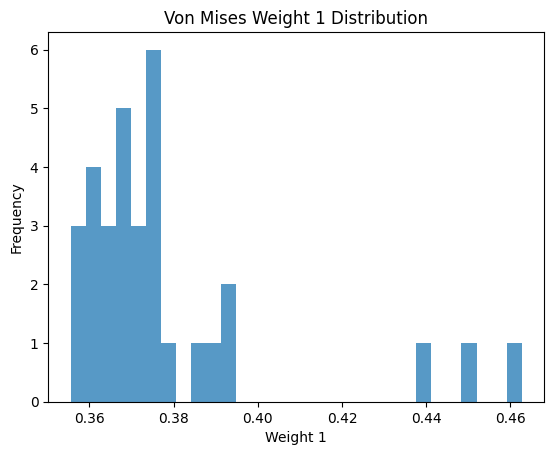

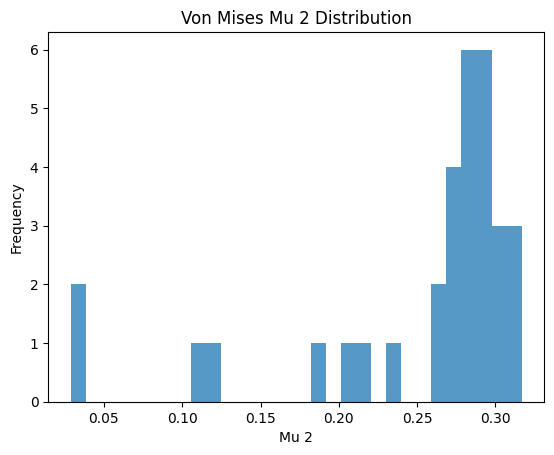

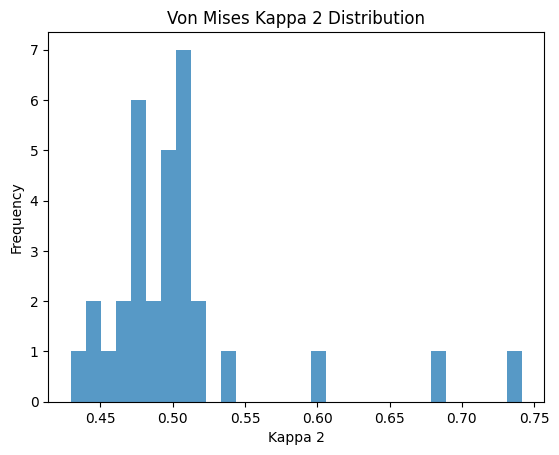

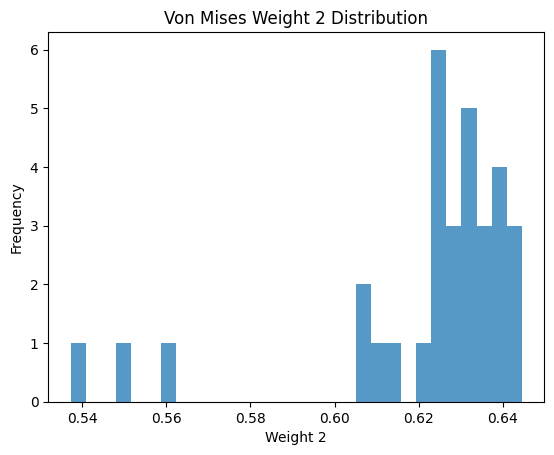

In [ ]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Extract parameters for each batch
gamma_shape1_list = []
gamma_scale1_list = []
gamma_weight1_list = []
gamma_shape2_list = []
gamma_scale2_list = []
gamma_weight2_list = []
vonmises_mu1_list = []
vonmises_kappa1_list = []
vonmises_weight1_list = []
vonmises_mu2_list = []
vonmises_kappa2_list = []
vonmises_weight2_list = []

for batch_output in intermediate_output:
    for sample_output in batch_output:
      # gamma_shape1, gamma_scale1, vonmises_mu1, vonmises_kappa1 = sample_output
      # gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = sample_output
      gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = sample_output

      gamma_shape1_list.append(torch.exp(gamma_shape1).item())
      gamma_scale1_list.append(torch.exp(gamma_scale1).item())
      gamma_weight1_list.append((torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
      gamma_shape2_list.append(torch.exp(gamma_shape2).item())
      gamma_scale2_list.append((torch.exp(gamma_scale2)*500).item())
      gamma_weight2_list.append((torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
      vonmises_mu1_list.append((vonmises_mu1 % (2*np.pi)).item())
      vonmises_kappa1_list.append(torch.exp(vonmises_kappa1).item())
      vonmises_weight1_list.append((torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())
      vonmises_mu2_list.append((vonmises_mu2 % (2*np.pi)).item())
      vonmises_kappa2_list.append(torch.exp(vonmises_kappa2).item())
      vonmises_weight2_list.append((torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())

# Plot parameters
def plot_histogram(data, title, xlabel):
    plt.figure()
    plt.hist(data, bins=30, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(gamma_shape1_list, 'Gamma Shape 1 Distribution', 'Shape 1')
plot_histogram(gamma_scale1_list, 'Gamma Scale 1 Distribution', 'Scale 1')
plot_histogram(gamma_weight1_list, 'Gamma Weight 1 Distribution', 'Weight 1')
plot_histogram(gamma_shape2_list, 'Gamma Shape 2 Distribution', 'Shape 2')
plot_histogram(gamma_scale2_list, 'Gamma Scale 2 Distribution', 'Scale 2')
plot_histogram(gamma_weight2_list, 'Gamma Weight 2 Distribution', 'Weight 2')
plot_histogram(vonmises_mu1_list, 'Von Mises Mu 1 Distribution', 'Mu 1')
plot_histogram(vonmises_kappa1_list, 'Von Mises Kappa 1 Distribution', 'Kappa 1')
plot_histogram(vonmises_weight1_list, 'Von Mises Weight 1 Distribution', 'Weight 1')
plot_histogram(vonmises_mu2_list, 'Von Mises Mu 2 Distribution', 'Mu 2')
plot_histogram(vonmises_kappa2_list, 'Von Mises Kappa 2 Distribution', 'Kappa 2')
plot_histogram(vonmises_weight2_list, 'Von Mises Weight 2 Distribution', 'Weight 2')

# Remove hook
hook_handle.remove()

tensor([[[-14.5482, -14.4791, -14.4105,  ..., -14.2017, -14.2680, -14.3349],
         [-14.4864, -14.4165, -14.3471,  ..., -14.1360, -14.2032, -14.2709],
         [-14.4252, -14.3545, -14.2843,  ..., -14.0710, -14.1390, -14.2075],
         ...,
         [-14.9054, -14.8396, -14.7744,  ..., -14.5475, -14.6105, -14.6741],
         [-14.9716, -14.9066, -14.8421,  ..., -14.6175, -14.6797, -14.7425],
         [-15.0383, -14.9740, -14.9103,  ..., -14.6879, -14.7494, -14.8114]]],
       device='cuda:0', dtype=torch.float64)
torch.Size([1, 101, 101])


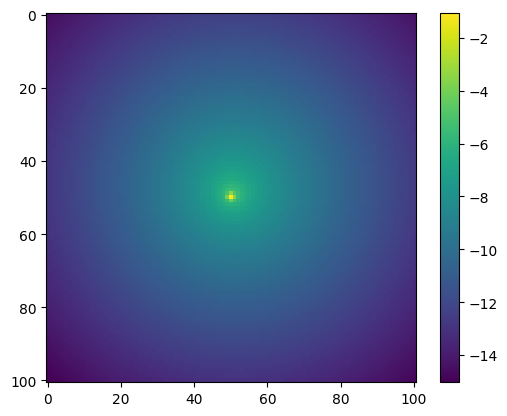

In [ ]:
test_bearing = torch.tensor([[1.0]], device=device)

test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass
# movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200), np.log(0.25), # gamma 1 - shape, scale and weight
#                                              np.log(2.5), np.log(300), np.log(0.75), # gamma 2 - shape, scale and weight
#                                              5, np.log(1), np.log(0.75),
#                                              -10, np.log(1.5), np.log(0.25)]], device=device), test_bearing)

movement_density = test_block(intermediate_output[0][0].unsqueeze(dim = 0), test_bearing)
# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)
print(movement_density.shape)

# plot the results of the movement density as an image
plt.imshow(movement_density.detach().cpu()[0])
plt.colorbar()
plt.show()

### Visualise CNN layers

In [ ]:
# Visualize the intermediate activations
# for layer_name, activation in activations.items():
#     print(f'Layer: {layer_name}, Shape: {activation.shape}')
#     plt.imshow(activation[0, 0].cpu().numpy(), cmap='gray')
#     plt.title(layer_name)
#     plt.show()